<a href="https://colab.research.google.com/github/monsieurshiva/AdvancedDeepLearning/blob/main/GenerativeDeepLearning/UNet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Brain Tumour Segmentation using Unet

Worldwide, incidences of brain tumours increases every year. Brain tumours are classified as benign (noncancerous tumours) and malignant (cancerous).Subclasses of brain tumours are primary and secondary tumours. Primary tumours start in the brain or Central Nervous Systems (CNS) whereas the secondary tumours spread from other body parts into the brain. Depends on the degree of abnormality of brain tissue, the tumours are type casted into four (1 to 4) grading levels. Tumours with 1 and 2 are low grades which are less dangerous. 3&4 grade tumours are high-grade tumours which are highly susceptible to cancer. Primary tumours have several types amongst 36.1 % all primary tumours are referred as meningioma that found near the top and outer curve of the brain. Meningioma is slowly growing noncancerous tumours that cause seizures and visual problems. Glioma is abnormal growth in glial cells presents around the neurons in the brain. Pituitary tumours grow in pituitary glands that affect body functions. Meningioma are iso-dense dura-based masses developed at the meninges of the three layers of protecting tissue of the brain and spinal cord, whose diagnosis depends on its anatomical location, shape and appearance of cells. Pituitary tumours are abnormal mass growth in cells around the surface of the pituitary gland that located at the base of skull.

For this work we have provided you the Meningioma tumor images along with its masks.

Build a Unet based segmentation model to segment the tumor region.

Dataset link:
https://drive.google.com/drive/folders/11rbveSfeTsTMwHsXyPzLGTN5SDfhWcR9?usp=sharing

#### Import the required libraries


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from tensorflow.keras.utils import normalize

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import CustomObjectScope
from glob import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from tqdm import tqdm
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
import pandas as pd


from tensorflow import keras
import segmentation_models as sm

#### Load the images and masks in one folder and properly resize to same size (If required)

In [ ]:
""" Global parameters """
H = 256
W = 256

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Display some of the images along with its mask and make sure the position of mask matches with original image tumor position

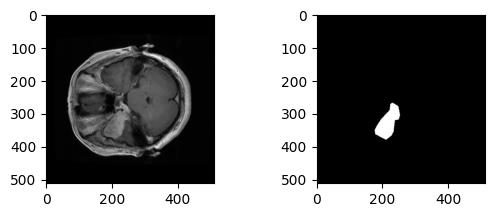

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Unet_dataset/images_brain_tum/img_0.jpg")
img_mask = cv2.imread("/content/drive/MyDrive/Unet_dataset/masks_brain_tum/img_0.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cvt_mask=cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_cvt)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_cvt_mask)



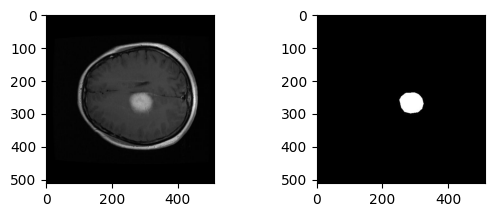

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Unet_dataset/images_brain_tum/img_1.jpg")
img_mask = cv2.imread("/content/drive/MyDrive/Unet_dataset/masks_brain_tum/img_1.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cvt_mask=cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_cvt)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_cvt_mask)


#### Write the function for Unet model. Properly define the ENCODER and DECODER section

In [ ]:
   """ Seeding """
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


In [ ]:

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:

    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                              

#### Define the Loss function and metric using Jecard coeff or dice coeff

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

#### Split the data into train and test. Call the Unet model and metric/loss functions defined in previous questions and compile and fit the model

In [ ]:

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [ ]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images_brain_tum", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks_brain_tum", "*.jpg")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [ ]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [ ]:
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
    """ Directory for storing files """
    create_dir("files")

In [ ]:
    """ Hyperparameters """
    batch_size = 3
    lr = 1e-4
    num_epochs = 500
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

In [ ]:
dataset_path = "/content/drive/MyDrive/Unet_dataset"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

In [ ]:
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


Train: 423 - 423
Valid: 141 - 141
Test : 141 - 141


In [ ]:
    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=10,
        validation_data=valid_dataset,
        callbacks=callbacks)

Epoch 1/10
141/141 [==============================] - ETA: 0s - loss: 0.8126 - dice_coef: 0.1874
Epoch 1: val_loss improved from inf to 0.94438, saving model to files/model.h5
141/141 [==============================] - 49s 246ms/step - loss: 0.8126 - dice_coef: 0.1874 - val_loss: 0.9444 - val_dice_coef: 0.0556 - lr: 1.0000e-04
Epoch 2/10
141/141 [==============================] - ETA: 0s - loss: 0.6802 - dice_coef: 0.3198
Epoch 2: val_loss did not improve from 0.94438
141/141 [==============================] - 33s 233ms/step - loss: 0.6802 - dice_coef: 0.3198 - val_loss: 0.9739 - val_dice_coef: 0.0261 - lr: 1.0000e-04
Epoch 3/10
141/141 [==============================] - ETA: 0s - loss: 0.5728 - dice_coef: 0.4272
Epoch 3: val_loss improved from 0.94438 to 0.82882, saving model to files/model.h5
141/141 [==============================] - 32s 228ms/step - loss: 0.5728 - dice_coef: 0.4272 - val_loss: 0.8288 - val_dice_coef: 0.1712 - lr: 1.0000e-04
Epoch 4/10
141/141 [=====================

#### Run with more iteration on Google colab for better result. As this segmentation process is tedius it will take lot iteration for convergence

In [ ]:
    model.fit(
        train_dataset,
        epochs=50,
        validation_data=valid_dataset,
        callbacks=callbacks)

Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 0.1615 - dice_coef: 0.8385
Epoch 1: val_loss did not improve from 0.21731
141/141 [==============================] - 31s 218ms/step - loss: 0.1615 - dice_coef: 0.8385 - val_loss: 0.3791 - val_dice_coef: 0.6209 - lr: 1.0000e-04
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 0.1273 - dice_coef: 0.8727
Epoch 2: val_loss improved from 0.21731 to 0.19876, saving model to files/model.h5
141/141 [==============================] - 34s 242ms/step - loss: 0.1273 - dice_coef: 0.8727 - val_loss: 0.1988 - val_dice_coef: 0.8012 - lr: 1.0000e-04
Epoch 3/50
141/141 [==============================] - ETA: 0s - loss: 0.1316 - dice_coef: 0.8684
Epoch 3: val_loss improved from 0.19876 to 0.14269, saving model to files/model.h5
141/141 [==============================] - 32s 227ms/step - loss: 0.1316 - dice_coef: 0.8684 - val_loss: 0.1427 - val_dice_coef: 0.8573 - lr: 1.0000e-04
Epoch 4/50
141/141 [=================

#### Evaluate the model performance on the test data and predict the segmented output for random test image. Plot the original image, original mask and predicted mask.

In [ ]:

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)



In [ ]:

    """ Directory for storing files """
    create_dir("results")

In [ ]:

    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

In [ ]:

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Unet_dataset"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)


In [ ]:

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("results", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

100%|██████████| 141/141 [00:27<00:00,  5.07it/s]

F1: 0.87057
Jaccard: 0.82203
Recall: 0.86557
Precision: 0.89555


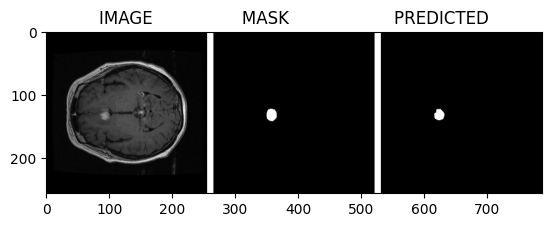

In [ ]:
img = cv2.imread("/content/results/img_100.jpg")
plt.title("IMAGE                 MASK                    PREDICTED")
plt.imshow(img)


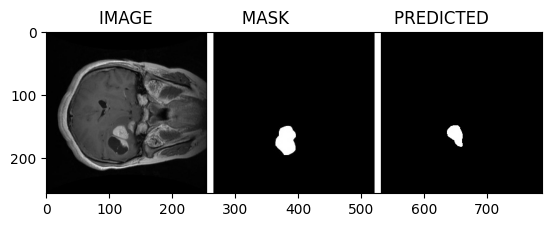

In [ ]:
img = cv2.imread("/content/results/img_128.jpg")
plt.title("IMAGE                 MASK                    PREDICTED")
plt.imshow(img)


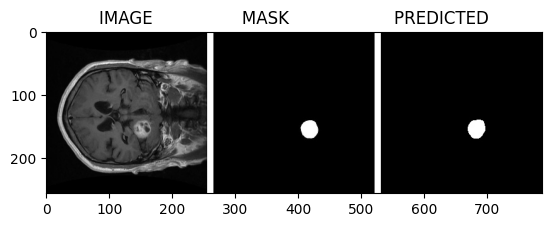

In [ ]:
img = cv2.imread("/content/results/img_183.jpg")
plt.title("IMAGE                 MASK                    PREDICTED")
plt.imshow(img)


#### Use some pretrained segmentation model from segmentation_model package to acheive the brain tumor segmentation task.

In [ ]:
model = sm.Unet()

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model = sm.Unet('resnet34', classes=1, activation='sigmoid')

85521592/85521592 [==============================] - 1s 0us/step


In [ ]:

(x_train, y_train), (x_val, y_val), (test_x, test_y) = load_dataset(dataset_path)

# define model
model = sm.Unet('resnet34', classes=1, activation='sigmoid')
model.compile(
    loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef]
)


model.fit(
        train_dataset,
        epochs=10,
        validation_data=valid_dataset,
        callbacks=callbacks)

Epoch 1/10
141/141 [==============================] - ETA: 0s - loss: 0.9124 - dice_coef: 0.0876
Epoch 1: val_loss did not improve from 0.09038
141/141 [==============================] - 39s 94ms/step - loss: 0.9124 - dice_coef: 0.0876 - val_loss: 0.9630 - val_dice_coef: 0.0370 - lr: 1.0000e-04
Epoch 2/10
141/141 [==============================] - ETA: 0s - loss: 0.7823 - dice_coef: 0.2177
Epoch 2: val_loss did not improve from 0.09038
141/141 [==============================] - 12s 86ms/step - loss: 0.7823 - dice_coef: 0.2177 - val_loss: 0.9732 - val_dice_coef: 0.0268 - lr: 1.0000e-04
Epoch 3/10
141/141 [==============================] - ETA: 0s - loss: 0.5494 - dice_coef: 0.4506
Epoch 3: val_loss did not improve from 0.09038
141/141 [==============================] - 11s 81ms/step - loss: 0.5494 - dice_coef: 0.4506 - val_loss: 0.9767 - val_dice_coef: 0.0233 - lr: 1.0000e-04
Epoch 4/10
141/141 [==============================] - ETA: 0s - loss: 0.3221 - dice_coef: 0.6779
Epoch 4: val_lo

In [ ]:
    """ Directory for storing files """
    create_dir("pretrainedresults")

In [ ]:

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("pretrainedresults", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/pretrainedscore.csv")

100%|██████████| 141/141 [00:24<00:00,  5.68it/s]

F1: 0.87978
Jaccard: 0.82352
Recall: 0.87297
Precision: 0.91018


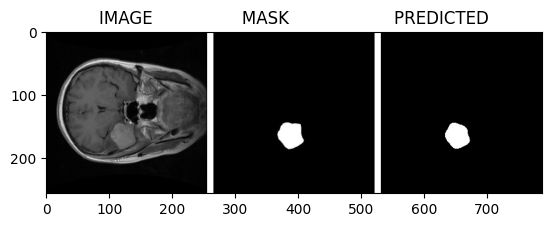

In [ ]:
img = cv2.imread("/content/pretrainedresults/img_282.jpg")
plt.title("IMAGE                 MASK                    PREDICTED")
plt.imshow(img)


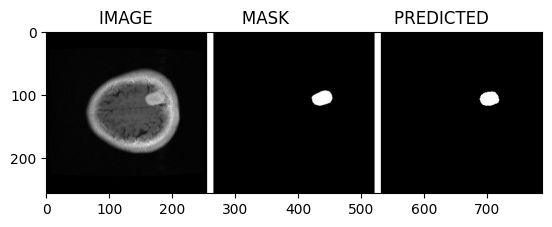

In [ ]:
img = cv2.imread("/content/pretrainedresults/img_47.jpg")
plt.title("IMAGE                 MASK                    PREDICTED")
plt.imshow(img)


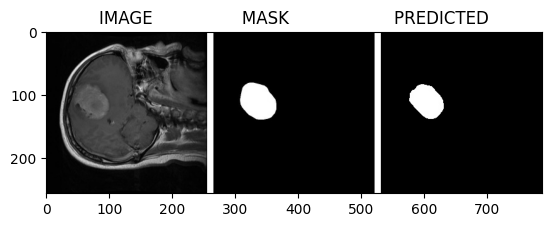

In [ ]:
img = cv2.imread("/content/pretrainedresults/img_562.jpg")
plt.title("IMAGE                 MASK                    PREDICTED")
plt.imshow(img)
